https://nbviewer.jupyter.org/gist/aflaxman/d4b1ce53b0817a1b7a71

 [-----------------100%-----------------] 10000 of 10000 complete in 2.3 sec

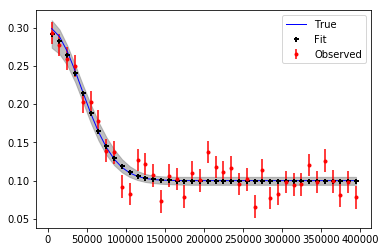

In [3]:
import pymc
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(5,400,10)*1e3

# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

# Gaussian function
gauss = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gauss(x=x,amp=amp_true, size=size_true, ps=ps_true )

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
f = f_true + noise 
f_error = np.ones_like(f_true)*0.05*f.max()

# define the model/function to be fitted.
def model(x, f): 
    amp = pymc.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pymc.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pymc.Normal('ps', 0.13, 40, value=0.15)

    @pymc.deterministic(plot=False)
    def gauss(x=x, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pymc.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pymc.MCMC(model(x,f))
MDL.sample(1e4)

# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=2, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()
plt.show()

In [6]:
import pymc as pm
# add noise to observed x values
x_obs = pymc.rnormal(mu=x, tau=(1e4)**-2)

# define the model/function to be fitted.
def model(x_obs, f): 
    amp = pymc.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pymc.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pymc.Normal('ps', 0.13, 40, value=0.15)

    x_pred = pymc.Normal('x', mu=x_obs, tau=(1e4)**-2) # this allows error in x_obs

    @pm.deterministic(plot=False)
    def gauss(x=x_pred, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pymc.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pymc.MCMC(model(x_obs, f))
MDL.use_step_method(pymc.AdaptiveMetropolis, MDL.x_pred) # use AdaptiveMetropolis to "learn" how to step
MDL.sample(200000, 100000, 10)  # run chain longer since there are more dimensions

 [-----------------100%-----------------] 200000 of 200000 complete in 68.5 sec

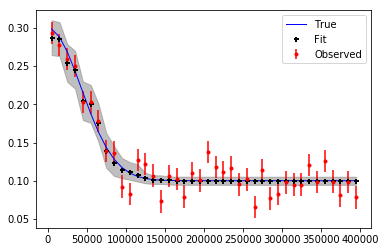

In [7]:
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=2, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()
plt.show()